In [1]:
import os
import numpy
import re
import random
from scipy.stats import gaussian_kde, pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.transforms as mtransforms
import math
import matplotlib.pyplot as plt

In [2]:
WORK_SPACE = os.getcwd()

In [3]:
def ahi_sr2sgli_sr(ahi_sr_array, AHI2MISR_para):
    slope = AHI2MISR_para[0]
    offset = AHI2MISR_para[1]
    offset_array = numpy.ones_like(ahi_sr_array)
    offset_array = offset_array * offset
    return ahi_sr_array * slope + offset_array


def identifer(data):
    down,up = numpy.nanpercentile(data,[0,75])
    IQR = up-down
    lower_limit = down - 1.5*IQR
    upper_limit = up + 1.5*IQR
    result = numpy.where(data > upper_limit,numpy.nan, data)
    result = numpy.where(result < lower_limit,numpy.nan, result)
    return result


def add_right_cax(ax, pad, width):

    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(axpos.x1 + pad, axpos.y0, axpos.x1 + pad + width, axpos.y1)
    cax = ax.figure.add_axes(caxpos)

    return cax


def mapping_scatter(Y, X,figure_title='demo', band_name='band3', axis_min=0.0, axis_max=0.5, save_flag=0):
    # filter    
#     if band_name == 'band3':
#         axis_max = 0.3
    
    lim_x = numpy.copy(X)
    lim_y = numpy.copy(Y)

    up4_x = numpy.quantile(lim_x, 0.98, interpolation='higher')
    up4_y = numpy.quantile(lim_y, 0.98, interpolation='higher')
    lim_x[lim_x > up4_x] = numpy.nan
    lim_y[lim_y > up4_y] = numpy.nan

    lim_mask = (lim_x*lim_y)*0+1
    temp_x = lim_x*lim_mask
    temp_y = lim_y*lim_mask
    temp_x = temp_x[~numpy.isnan(temp_x)]
    temp_y = temp_y[~numpy.isnan(temp_y)]
    
    diff_array = abs(numpy.array(temp_y)-numpy.array(temp_x))/abs(numpy.minimum(numpy.array(temp_x), numpy.array(temp_y)))
    diff_array_filtered = numpy.array(identifer(diff_array))
    show_x = (diff_array_filtered*0+1)*temp_x
    show_y = (diff_array_filtered*0+1)*temp_y
    
    x_o = show_x[~numpy.isnan(show_x)]
    y_o = show_y[~numpy.isnan(show_y)]

    fig = plt.figure(figsize=(4, 4))
    ax1 = fig.add_subplot(111, aspect='equal',facecolor='whitesmoke', alpha=0.1)
    ax1.grid(linestyle='--', linewidth=0.3)

    model = LinearRegression()
    x = x_o.reshape(-1, 1)
    model.fit(x, y_o)
    y_pred = model.predict(x)
    xx = numpy.arange(axis_min, axis_max + 0.1, 0.05)
    k = model.coef_[0]
    b = model.intercept_
    yy = k * xx + b
    
    N = len(x_o)
    x = numpy.arange(axis_min, axis_max + 1)
    y = 1 * x

#     g_x, g_y = numpy.mgrid[axis_min:axis_max:500j, axis_min:axis_max:500j]
#     positions = numpy.vstack([g_x.ravel(), g_y.ravel()])
#     values = numpy.vstack([X, Y])
#     kernel = gaussian_kde(values)
#     Z = numpy.reshape(kernel(positions).T, g_x.shape)
    
    # Calculate the point density
    xy = numpy.vstack([x_o, y_o])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x_, y_, z = x_o[idx], y_o[idx], z[idx]
    z = (z-numpy.min(z))/(numpy.max(z)-numpy.min(z))*100
    im = ax1.scatter(x_, y_, marker='o', c=z, s=8, cmap='turbo')
    
    # Calculate parameters
    r2 = r2_score(y_o, x_o)
    rmse = numpy.sqrt(mean_squared_error(y_o, x_o))
    rmse_r = (rmse/numpy.mean(x_o))*100 # %
    bias = numpy.mean(y_o-x_o)
    bias_r = (bias/numpy.mean(x_o))*100 # %
    r_, p = pearsonr(x_o, y_o)
    p_str = '%.3e' % p
    
    print('R²:', r2)
    print('relative RMSE (%):', rmse_r)
    print('RMSE:', rmse)
    print('relative Bias (%):', bias_r)
    print('Bias:', bias)
    print('r_:', bias)    

    ax1.minorticks_on()
    x_major_locator = plt.MultipleLocator(0.1)
    x_minor_locator = plt.MultipleLocator(0.05)
    ticks_interval = 0.1
    if band_name == 'band4':
        x_major_locator = plt.MultipleLocator(0.2)
        x_minor_locator = plt.MultipleLocator(0.1)
        ticks_interval = 0.2
    ax1.xaxis.set_minor_locator(x_minor_locator)
    ax1.xaxis.set_major_locator(x_major_locator)
    ax1.yaxis.set_minor_locator(x_minor_locator)
    ax1.yaxis.set_major_locator(x_major_locator)
    ax1.set_xticks(numpy.arange(axis_min, axis_max + ticks_interval, ticks_interval))
    ax1.set_yticks(numpy.arange(axis_min+ticks_interval, axis_max-ticks_interval, ticks_interval))

    ax1.tick_params(axis="y", which='minor', length=3, direction='in', labelsize=15)
    ax1.tick_params(axis="y", which='major', length=5, direction='in', labelsize=15)

    ax1.tick_params(axis="x", which='minor', length=3, direction='in', labelsize=15)
    ax1.tick_params(axis="x", which='major', length=5, direction='in', labelsize=15)

    # ax1.spines['right'].set_color('none')
    # ax1.spines['top'].set_color('none')
    ax1.spines['left'].set_linewidth(1)
    ax1.spines['bottom'].set_linewidth(1)


    band_label = {
        'band3': 'Band3',
        'band4': 'Band4',
    }
    
    ax1.set_ylabel("AHI LSR", fontsize=15)
    ax1.set_xlabel("SGLI LSR", fontsize=15)

#     ax1.imshow(numpy.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[axis_min, axis_max, axis_min, axis_max], alpha=0.8, zorder=0)
#     ax1.plot(X, Y, 'k.', markersize=0.5, alpha=0.8, zorder=4)
    ax1.plot(x, y, color='k', linewidth=1, linestyle='-', zorder=1)
    ax1.plot(xx, yy, color='r', linewidth=1, linestyle='-.', zorder=2)
    
#     label_str = 'y = {}x + {}\nRMSE = {}\nr = {}\n'.format(round(k, 2), round(b, 2), round(rmse, 3), round(r_, 2))
#     if b < 0:
#         label_str = 'y = {}x - {}\nRMSE = {}\nr = {}\n'.format(round(k, 2), abs(round(b, 2)), round(rmse, 3), round(r_, 2))

#     text_x = axis_min + (axis_max - axis_min) * 0.07
#     text_y = axis_max - (axis_max - axis_min) * 0.35
#     ax1.text(text_x, text_y, s=label_str, fontsize=18)
    
#     band_label = band_label[band_name]
#     text_x2 = axis_min + (axis_max - axis_min) * 0.7
#     text_y2 = axis_min + (axis_max - axis_min) * 0.1
#     if band_name == 'band3':
#         ax1.text(text_x2, text_y2, color='red', s=band_label, fontsize=18)
#     else:
#         ax1.text(text_x2, text_y2, color='firebrick', s=band_label, fontsize=18)
    
    label_str = 'y = {}x + {}\nRRMSE: {}%\nRbias: {}%\nr: {}'.format(round(k, 2), round(b, 2), round(rmse_r, 2), round(bias_r, 2),round(r_, 2))
    if b < 0:
        label_str = 'y = {}x + {}\nRRMSE: {}%\nRbias: {}%\nr: {}'.format(round(k, 2), round(b, 2), round(rmse_r, 2), round(bias_r, 2),round(r_, 2))

    text_x = axis_min+(axis_max - axis_min)*0.024
    text_y = axis_max-(axis_max - axis_min)*0.368
    ax1.text(text_x, text_y, s=label_str, fontsize=18)
            
    label_str2 = 'R²: {}\nbias: {}\nRMSE: {}\n'.format(round(r2, 2), round(bias, 3), round(rmse, 3))
    text_x2 = axis_max-(axis_max - axis_min)*0.02
    text_y2 = axis_min-(axis_max - axis_min)*0.06
    ax1.text(text_x2, text_y2, s=label_str2, fontsize=18, horizontalalignment='right')

    cax = add_right_cax(ax1, pad=0.01, width=0.03)
    cb = fig.colorbar(im, cax=cax)
    
    ax1.set_xlim(axis_min, axis_max)
    ax1.set_ylim(axis_min, axis_max)
    
    mapping_folder = os.path.join(WORK_SPACE, 'Scatter_LC_SR')
    figure_folder = os.path.join(mapping_folder, str(PIXEL_PAIRS_MAX))
    if not os.path.exists(figure_folder):
        os.makedirs(figure_folder)
    fig_filename = os.path.join(figure_folder, figure_title + '.png')
    fig.savefig(fig_filename, dpi=1000, bbox_inches='tight')
    print(fig_filename)
    plt.show()
    plt.clf()
    # slope r RMSE
    return k, r_, rmse

In [4]:
def progress(band4_ahi_npy, band4_sgli_npy):
    band4_ahi = numpy.load(band4_ahi_npy)
    band4_sgli = numpy.load(band4_sgli_npy)

    lim_mask = (band4_sgli*band4_ahi)*0+1
    temp_x = band4_sgli*lim_mask
    temp_y = band4_ahi*lim_mask
    temp_x = temp_x[~numpy.isnan(temp_x)]
    temp_y = temp_y[~numpy.isnan(temp_y)]

    index_array = random.sample([idx for idx in range(len(temp_x))], PIXEL_PAIRS_MAX)
    index_array = numpy.sort(index_array).tolist()

    sgli_SR_band4_pts = numpy.array(temp_x)
    b4_sgli_array = sgli_SR_band4_pts[index_array]
    ahi_SR_band4_pts = numpy.array(temp_y)
    b4_ahi_array = ahi_SR_band4_pts[index_array]
    
    return b4_ahi_array, b4_sgli_array

In [5]:
PIXEL_PAIRS_MAX = 350

## Band4

C:\Users\Beichen\AppData\Local\Temp\ipykernel_45816\2255264422.py:36: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  up4_x = numpy.quantile(lim_x, 0.98, interpolation='higher')
C:\Users\Beichen\AppData\Local\Temp\ipykernel_45816\2255264422.py:37: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  up4_y = numpy.quantile(lim_y, 0.98, interpolation='higher')


R²: 0.6923051474221654
relative RMSE (%): 20.845909597717675
RMSE: 0.055824332119850356
relative Bias (%): 2.074614106414421
Bias: 0.005555715683890577
r_: 0.005555715683890577
D:\PhD_Workspace\MISR_AHI_WS\230728\AHI_SGLI_Jan\Scatter_LC_SR\350\AHI-SGLI_RAA_NZL_Jan_Grassland_B4.png


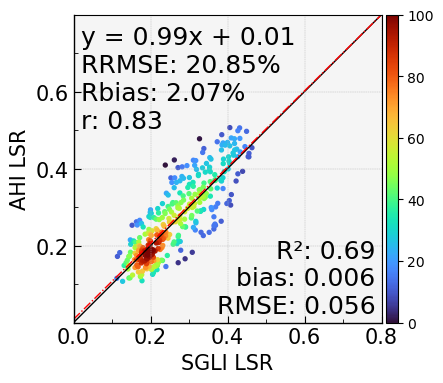

(0.9892762601648452, 0.8339271137741882, 0.055824332119850356)

<Figure size 640x480 with 0 Axes>

In [6]:
band4_ahi_npy = './2019_Jan_B04.npy'
band4_sgli_npy = './2019_Jan_PI02.npy'
b4_ahi_array, b4_sgli_array = progress(band4_ahi_npy, band4_sgli_npy)
b4_ahi_array = ahi_sr2sgli_sr(b4_ahi_array, [1.016, -0.00003066])
mapping_scatter(b4_ahi_array, b4_sgli_array, figure_title='AHI-SGLI_RAA_NZL_Jan_Grassland_B4', band_name='band4', axis_min=0.0, axis_max=0.8)

R²: 0.5479505612011502
relative RMSE (%): 18.766228527928742
RMSE: 0.04003200496105924
relative Bias (%): 10.844030291752011
Bias: 0.023132419696969678
r_: 0.023132419696969678


C:\Users\Beichen\AppData\Local\Temp\ipykernel_45816\2255264422.py:36: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  up4_x = numpy.quantile(lim_x, 0.98, interpolation='higher')
C:\Users\Beichen\AppData\Local\Temp\ipykernel_45816\2255264422.py:37: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  up4_y = numpy.quantile(lim_y, 0.98, interpolation='higher')


D:\PhD_Workspace\MISR_AHI_WS\230728\AHI_SGLI_Jan\Scatter_LC_SR\350\AHI-SGLI_RAA_NZL_Jan_EBF_B4.png


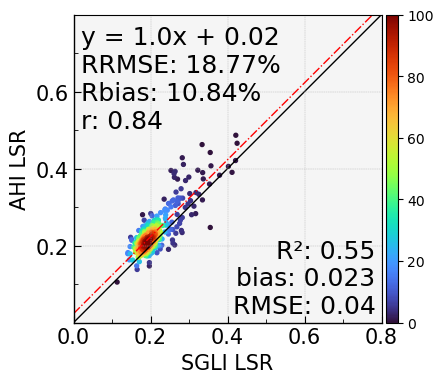

(0.9992163527889005, 0.8359988815926296, 0.04003200496105924)

<Figure size 640x480 with 0 Axes>

In [7]:
band4_ahi_npy = './2019_Jan_B04_EBF.npy'
band4_sgli_npy = './2019_Jan_PI02_EBF.npy'
b4_ahi_array, b4_sgli_array = progress(band4_ahi_npy, band4_sgli_npy)
b4_ahi_array = ahi_sr2sgli_sr(b4_ahi_array, [1.035, -0.0002806])
mapping_scatter(b4_ahi_array, b4_sgli_array, figure_title='AHI-SGLI_RAA_NZL_Jan_EBF_B4', band_name='band4', axis_min=0.0, axis_max=0.8)